# Display a random image with its ground truth bounding box

This code cell selects a random image from a dataset along with its corresponding bounding box annotation. The code opens the image using `PIL`, reads the annotation file, and draws a bounding box on the image. Finally, it displays the image with the bounding box using `matplotlib`. 

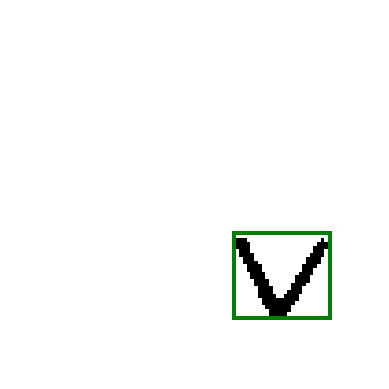

In [1]:
import os
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from IPython.display import display

cwd = os.getcwd() # get the current working directory

# get the list of images and their labels
listdir = os.listdir(os.path.join(cwd, "images_and_labels"))

# generate a random number within the range of available files
random_num = random.randint(1, int(len(listdir)/2))
random_num_formatted = f"{random_num:04d}"

random_image_path = os.path.join(cwd, f"images_and_labels/{random_num_formatted}.png") # path to the randomly selected image
annotation_path = os.path.join(cwd, f"images_and_labels/{random_num_formatted}.txt") # path to the corresponding annotation file

# create a PIL image
image = Image.open(random_image_path)

# read the annotation file
with open(annotation_path, 'r') as f:
    annotation = f.readline().split()

# extract the bounding box coordinates
x, y, w, h = map(float, annotation[1:])

left = int((x - w/2) * image.width)         # left coordinate of the bounding box
top = int((y - h/2) * image.height)         # top coordinate of the bounding box
right = int((x + w/2) * image.width)        # right coordinate of the bounding box
bottom = int((y + h/2) * image.height)      # bottom coordinate of the bounding box

# create a drawing object and draw the bounding box
draw = ImageDraw.Draw(image)
draw.rectangle([left, top, right, bottom], outline="green", width=1)

plt.imshow(image) # display the image with its bounding box
plt.axis("off")
plt.show()

# Prepare dataset

Prepares the dataset by creating a list of image paths and a list of corresponding ground truth label paths. Then processeses the label files, extracting the class labels and bounding box coordinates, and stores them as a list of lists. Finally, reads and normalizes each image using `OpenCV`, converting them to float32 format and scaling pixel values between 0 and 1. The resulting images are stored in a separate list.

In [2]:
import cv2

dataset_path = os.path.join(cwd, "images_and_labels")

# create a list of image and label paths
image_paths = [os.path.join(dataset_path, filename) for filename in os.listdir(dataset_path) if filename.endswith(".png")]
text_paths = [os.path.join(dataset_path, filename) for filename in os.listdir(dataset_path) if filename.endswith("txt")]

# initialize an empty list to store the class labels
# and bounding box coordinates 
labels_and_coord = []

# iterate over text files
for text_file in text_paths:
    with open(text_file, "r") as file:
        # read all lines in the file
        line = file.readlines()
        values = line[0].split()
        # extract class label and bouding box coordinates
        class_label, x, y, w, h = [float(value) for value in values]
    labels_and_coord.append([class_label, x, y, w, h])

# initialize and empty list to store images
images = []

# iterate over images
for image_path in image_paths:
    # read the image using OpenCV
    image = cv2.imread(image_path)
    # convert the image data type to float32 and normalize pixel values
    image = image.astype("float32") / 255.
    images.append(image)

# Split dataset into train and test sets
Using `train_test_split` function from scikit-learn library this code cell splits the dataset into training and test sets. The split is performed with a test size of 30% and a random state of 42.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels_and_coord, test_size=0.3, shuffle=True, random_state=42)

# Seperate class labels and bounding box coordinates
Class labels and bounding box coordinates are extracted fron the `y_train` and `y_test` lists and organized into seperate arrays. The labels are stored in `y_train_labels` and `y_test_labels` as 1-D arrays, and the bounding box coordinates are stored in `y_train_bbox` and `y_test_bbox` as 2-D arrays. Finally all these arrays, along with `X_train` and `X_test` which are input images, are converted to `numpy` arrays.

In [4]:
import numpy as np

# initialize empty lists to store the class labels and bounding box coordinates
y_train_labels = []
y_test_labels = []
y_train_bbox = []
y_test_bbox = []

# extract the labels from y_train list and append them to y_train_labels
for i in range(len(y_train)):
    y_train_labels.append(y_train[i][0])
# do the same as above for test set
for i in range(len(y_test)):
    y_test_labels.append(y_test[i][0])

# extract the bounding box coordinates from y_train list and
# append them to y_train_bbox
for i in range(len(y_train)):
    y_train_bbox.append(y_train[i][1:])
# do the same as above for test set
for i in range(len(y_test)):
    y_test_bbox.append(y_test[i][1:])

# convert the input images to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# convert the class labels and bounding boxes to numpy arrays
y_train_labels = np.array(y_train_labels)
y_test_labels = np.array(y_test_labels)
y_train_bbox = np.array(y_train_bbox)
y_test_bbox = np.array(y_test_bbox)

# Build a CNN model with class and bouding box outputs using TensorFlow

The model has two main outputs:
- `output_class` for class prediction and
- `output_box` for bounding box prediction

The CNN architecture consists of multiple convolutional layers, max pooling layers, and dense layers. Regularization techniques are applied to some of the layers for improved model performance.

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


def get_model():
    """
    Creates a CNN model with class and bounding box outputs.

    The model consists of two branches:
    - one for class prediction and 
    - the other for bounding box prediction.
    The class prediction branch uses convolutional layers with 5x5 kernels and max pooling layers with
    2x2 pooling. The bounding box prediction branch uses convolutional layers with 3x3 kernels and max
    pooling layers with 2x2 pooling. Both branches have a series of convolutional layers followed by
    max pooling and dense layers.

    Returns:
        model (tf.keras.Model): Uncompiled CNN model with class and bounding box outputs.
    """

    # define the input layer 
    inputs = Input(shape=(100,100,3), name="image")

    # class prediction branch
    x = Conv2D(filters=8, kernel_size=(5,5), padding = "valid", activation="relu", name="Layer1_Conv2D")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name="Layer1_MaxPooling")(x)
    x = Conv2D(filters=16, kernel_size=(5,5), padding="valid", activation="relu", name="Layer2_Conv2D")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name="Layer2_MaxPooling")(x)
    x = Conv2D(filters=16, kernel_size=(5,5), padding = "valid", activation="relu", name="Layer3_Conv2D")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name="Layer3_MaxPooling")(x)
    x = Flatten(name="Flatten_1")(x)
    x = Dense(units=120, activation="relu", name="Layer4_Dense")(x)
    x = Dense(units=84, activation="relu", name="Layer5_Dense")(x)
    output_class = Dense(units=3, activation="softmax", name="Output_Class")(x)

    # bounding box prediction branch
    x2 = Conv2D(filters=16, kernel_size=(3,3), padding = "valid", activation="relu", name="Layer6_Conv2D")(inputs)
    x2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name="Layer6_MaxPooling")(x2)
    x2 = Conv2D(filters=32, kernel_size=(3,3), padding="valid", activation="relu", name="Layer7_Conv2D")(x2)
    x2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), name="Layer7_MaxPooling")(x2)
    x2 = Conv2D(filters=16, kernel_size=(3,3), padding = "valid", activation="relu", name="Layer8_Conv2D")(x2)
    x2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), name="Layer8_MaxPooling")(x2)
    x2 = Conv2D(filters=32, kernel_size=(3,3), padding="valid", activation="relu", name="Layer9_Conv2D")(x2)
    x2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), name="Layer9_MaxPooling")(x2)
    x2 = Flatten(name="Flatten_2")(x2)
    x2 = Dense(units=32, kernel_regularizer=regularizers.L2(l2=1e-4),
               activation="relu", name="Layer25_Dense")(x2)
    x2 = Dense(units=32, activation="relu", name="Layer26_Dense")(x2)
    x2 = Dense(units=32, kernel_regularizer=regularizers.L2(l2=1e-4),
               activation="relu", name="Layer27_Dense")(x2)
    x2 = Dense(units=32, activation="relu", name="Layer28_Dense")(x2)
    output_box = Dense(units=4, name="Output_Box")(x2)
    
    # define the model
    model = Model(inputs=inputs, outputs=[output_class, output_box], name="CNN_Model")

    return model

# Plot the CNN model and get summary

In [6]:
from tensorflow.keras.utils import plot_model

# create an instance of the CNN model
cnn_model = get_model()

# generate a visualization of the model's architecture
plot_model(cnn_model)

# print a summary of the model
cnn_model.summary()

Model: "CNN_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Layer6_Conv2D (Conv2D)         (None, 98, 98, 16)   448         ['image[0][0]']                  
                                                                                                  
 Layer6_MaxPooling (MaxPooling2  (None, 49, 49, 16)  0           ['Layer6_Conv2D[0][0]']          
 D)                                                                                               
                                                                                          

# IoU metric class definition
This code cell defines a custom metric class that calculates the IoU between predicted and ground truth bounding box.

In [7]:
from tensorflow.keras import backend as K

class IoU(tf.keras.metrics.Metric):
    """ custom IoU metric class """

    def __init__(self, name='iou', **kwargs):
        """
        initializes the IoU metric
        Args:
            name (str): name of the metric
            **kwargs: additional arguments to be passed to the base class
        """
        super(IoU, self).__init__(name=name, **kwargs)
        self.intersection = self.add_weight(name='intersection', initializer='zeros')
        self.union = self.add_weight(name='union', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        updates the metric state with new predictions and ground truth
        Args:
            y_true (tensor): ground truth bounding box
            y_pred (tensor): predicted bounding boxes
            sample_weight: optional weighting of the samples
        """
        # convert center coordinates and dimensions to bounding box coordinates
        y_true = K.concatenate([y_true[:, :2] - y_true[:, 2:] / 2, y_true[:, :2] + y_true[:, 2:] / 2])
        y_pred = K.concatenate([y_pred[:, :2] - y_pred[:, 2:] / 2, y_pred[:, :2] + y_pred[:, 2:] / 2])

        # compute the intersection and union of the bounding boxes
        xmin = K.maximum(y_true[:, 0], y_pred[:, 0])
        ymin = K.maximum(y_true[:, 1], y_pred[:, 1])
        xmax = K.minimum(y_true[:, 2], y_pred[:, 2])
        ymax = K.minimum(y_true[:, 3], y_pred[:, 3])
        intersection = K.maximum(xmax - xmin, 0) * K.maximum(ymax - ymin, 0)
        union = (y_true[:, 2] - y_true[:, 0]) * (y_true[:, 3] - y_true[:, 1]) + (y_pred[:, 2] - y_pred[:, 0]) * (y_pred[:, 3] - y_pred[:, 1]) - intersection
        self.intersection.assign_add(K.sum(intersection))
        self.union.assign_add(K.sum(union))

    def result(self):
        """
        calculates the IoU metric
        returns:
            calculated IoU metric value
        """
        return self.intersection / (self.union + K.epsilon())

    def reset_state(self):
        """ resets the metric state """
        self.intersection.assign(0)
        self.union.assign(0)


# Compile the model
Optimizer:
- Adam (with learning rate = 0.005)

Losses:
- `Sparse Categorical Crossentropy` for image classification task
- `Mean Squared Error` for regression task

Metrics:
- `Accuracy` metric for classification task
- `IoU` metric for object localization task

In [8]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.005)

cnn_model.compile(optimizer=optimizer,
                  loss={"Output_Class":"sparse_categorical_crossentropy", "Output_Box":"mse"},
                  metrics={"Output_Class":"accuracy", "Output_Box":IoU(name="iou")})

Define a learning rate scheduler

In [9]:
def lr_schedule(epoch, lr):
    """
    This function adjusts the learning rate based on the current epoch and divides it
    by 1.25 each 5 epochs.

    Args:
        epoch (int): current epoch number
        lr (float): current learning rate
    Returns:
        updated learning rate        
    """
    if (epoch) % 5 == 0:
        lr /= 1.25
    return max(lr, 3e-7)

# Train the model
Train the `cnn_model` using the `fit` method using `lr_schedule` function defined above as a callback to adjust the learning rate during training.

In [10]:
history = cnn_model.fit(x=X_train, y={"Output_Class":y_train_labels, "Output_Box":y_train_bbox},
                        epochs=5, verbose=False,
                        validation_data=(X_test, {"Output_Class":y_test_labels, "Output_Box":y_test_bbox}),
                        callbacks=tf.keras.callbacks.LearningRateScheduler(lr_schedule))

### Evaluate the performance of the model

In [11]:
results = cnn_model.evaluate(X_test, {"Output_Class":y_test_labels, "Output_Box":y_test_bbox}, verbose=False)

print(f"Class Accuracy: {results[3]*100:.3f}%")
print(f"IoU:\t\t{results[-1]*100:.3f}%")

Class Accuracy: 69.412%
IoU:		61.362%


### Plot IoU
Plot the history of IoU metrics during the training

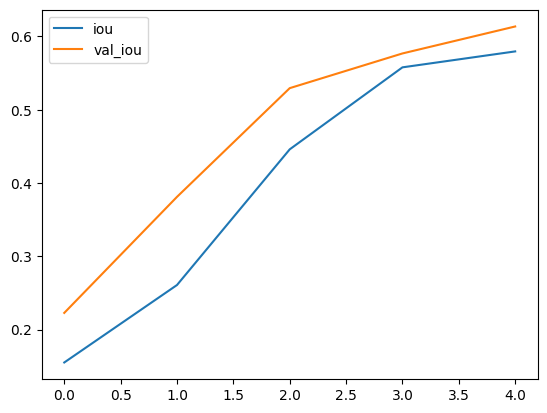

In [12]:
# get the history of IoU metric both for training and validation sets
plt.plot(history.history["Output_Box_iou"], label="iou")
plt.plot(history.history["val_Output_Box_iou"], label="val_iou")

plt.legend()
plt.show()

# Predict on test data
Use the trained `cnn_model` to make predictions on the test data

In [13]:
test_prediction = cnn_model.predict(X_test)

# prediction[0] =====> class labels
# prediction[1] =====> bounding boxes

6/6 [==============================] - 0s 19ms/step


# Visualize the predictions on test data

Plot some test images along with their corresponding labels and bounding box predictions

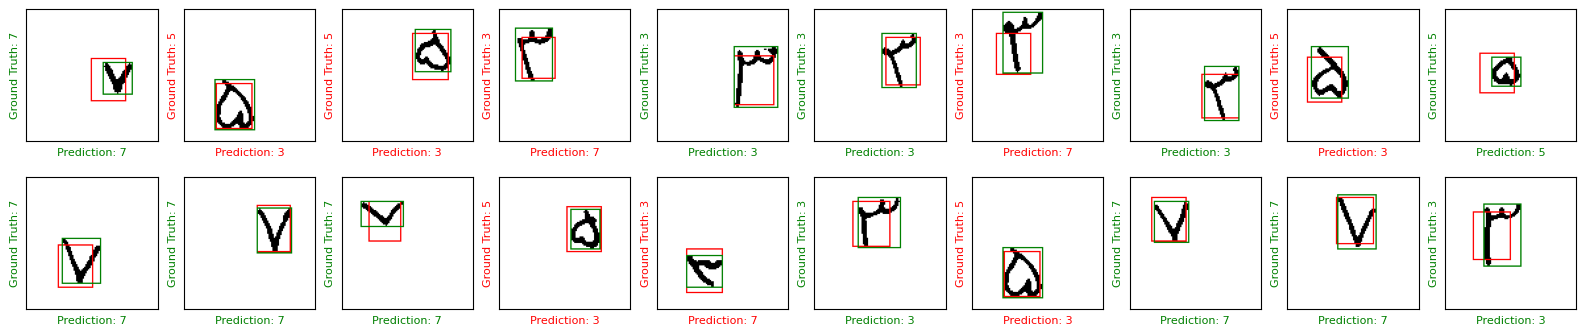

In [14]:
# create a figure with 2 rows and 10 columns
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

# flatten the subplots array into a 1-D array
axs = axs.flatten()

# create a list of random numbers to be used later
random_numbers = []

# iterate over a range of 20 to display 20 random images
for i in range(20):
    # generate a random number within the range of the test data
    random_num = random.randint(1, len(X_test)-1)
    random_numbers.append(random_num)
    # get the index of the highest predicted class probability
    index = np.argmax(test_prediction[0][random_num])
    # get the target class label from the test labels
    target = y_test_labels[random_num]

    # set the font color based on whether the prediction matches the target label
    color = "green" if int(index) == int(target) else "red"

    # determine the predicted class label based on the index
    if index == 0:
        pred = 3
    elif index == 1:
        pred = 5
    elif index == 2:
        pred = 7

    # determine the target class label
    if target == 0:
        label = 3
    elif target == 1:
        label = 5
    elif target == 2:
        label = 7

    # convert the image data from the test set to array format 
    array = X_test[random_num]*255
    array = array.astype(np.uint8)
    # create a PIL image from the array
    pil_image = Image.fromarray(array)

    # extract ground truth bounding box coordinates
    gt_x, gt_y, gt_w, gt_h = y_test_bbox[random_num]
    gt_left = int((gt_x - gt_w/2) * pil_image.width)
    gt_top = int((gt_y - gt_h/2) * pil_image.height)
    gt_right = int((gt_x + gt_w/2) * pil_image.width)
    gt_bottom = int((gt_y + gt_h/2) * pil_image.height)

    # extract predicted bounding box coordinates
    x, y, w, h = test_prediction[1][random_num]
    left = int((x - w/2) * pil_image.width)
    top = int((y - h/2) * pil_image.height)
    right = int((x + w/2) * pil_image.width)
    bottom = int((y + h/2) * pil_image.height)

    # draw the bounding box on the image
    draw = ImageDraw.Draw(pil_image)
    draw.rectangle([left, top, right, bottom], outline="red", width=1)
    draw.rectangle([gt_left, gt_top, gt_right, gt_bottom], outline="green", width=1)

    # set plot settings
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel(f"Prediction: {pred}", color=color, fontsize=8, labelpad=1)
    axs[i].set_ylabel(f"Ground Truth: {label}", color=color, fontsize=8, labelpad=1)
    axs[i].imshow(X_test[random_num])
    axs[i].imshow(pil_image)


The plot displayed above complements the earlier observations on the model's accuracy and IoU metrics. It vividly illustrates the limitations of the current model's performance. The plot showcases instances where the model misclassifies certain images and exhibits imprecise object localization. Evidently, the model would benefit from further training iterations to enhance its capabilities in accurate classification and precise localization tasks.

# Train more
Train the model for more 50 epochs

In [15]:
history = cnn_model.fit(x=X_train, y={"Output_Class":y_train_labels, "Output_Box":y_train_bbox},
                        epochs=50, verbose=False,
                        validation_data=(X_test, {"Output_Class":y_test_labels, "Output_Box":y_test_bbox}),
                        callbacks=tf.keras.callbacks.LearningRateScheduler(lr_schedule))

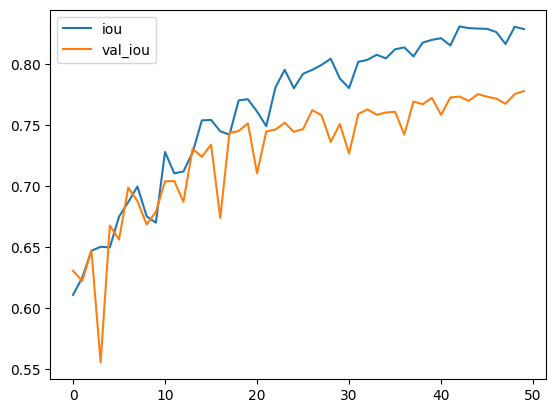

In [16]:
# get the history of IoU metric both for training and validation sets
plt.plot(history.history["Output_Box_iou"], label="iou")
plt.plot(history.history["val_Output_Box_iou"], label="val_iou")

plt.legend()
plt.show()

### Evaluate the performance of the more trained model

In [17]:
results = cnn_model.evaluate(X_test, {"Output_Class":y_test_labels, "Output_Box":y_test_bbox}, verbose=False)

print(f"Class Accuracy: {results[3]*100:.3f}%")
print(f"IoU:\t\t{results[-1]*100:.3f}%")

Class Accuracy: 98.235%
IoU:		77.791%


After an additional 50 epochs of training, significant improvements were observed in the model's performance. The updated model exhibited better accuracy and precision in classifying and localizing objects within images. This was evident from the plotted curves of the IoU metric, which showed a steady increase over the training period.

The IoU curves of both the train and test sets revealed a noticeable discrepancy, indicating the presence of overfitting. However, it is important to note that the overfitting observed in this case can be attributed to the limited size of the dataset rather than any inherent issue with the model architecture.

### Predict on test images with more trained model

In [18]:
test_prediction = cnn_model.predict(X_test)

6/6 [==============================] - 0s 18ms/step


# Plot the results of the more trained model

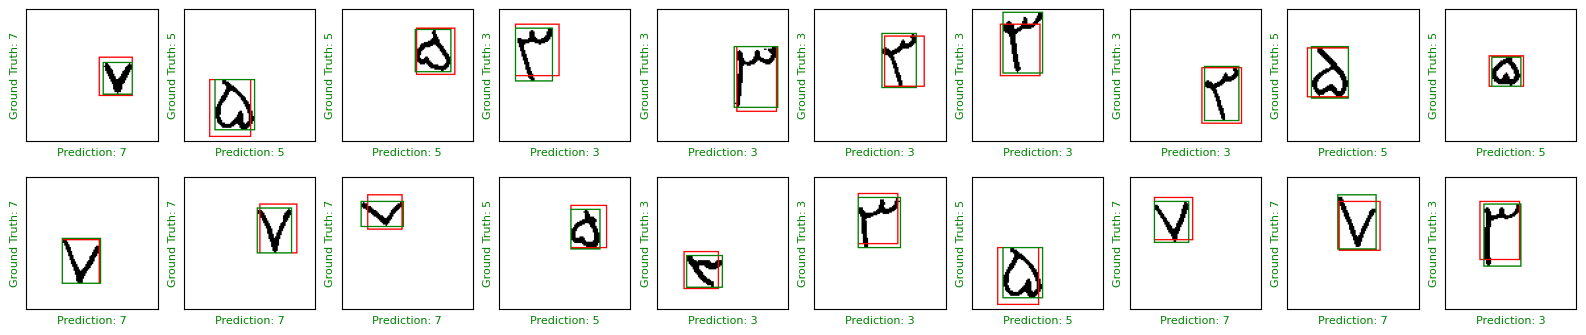

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))
axs = axs.flatten()

for i in range(20):
    number = random_numbers[i]
    index = np.argmax(test_prediction[0][number])
    target = y_test_labels[number]

    color = "green" if int(index) == int(target) else "red"

    if index == 0:
        pred = 3
    elif index == 1:
        pred = 5
    elif index == 2:
        pred = 7

    if target == 0:
        label = 3
    elif target == 1:
        label = 5
    elif target == 2:
        label = 7

    array = X_test[number]*255
    array = array.astype(np.uint8)
    pil_image = Image.fromarray(array)

    gt_x, gt_y, gt_w, gt_h = y_test_bbox[number]
    gt_left = int((gt_x - gt_w/2) * pil_image.width)
    gt_top = int((gt_y - gt_h/2) * pil_image.height)
    gt_right = int((gt_x + gt_w/2) * pil_image.width)
    gt_bottom = int((gt_y + gt_h/2) * pil_image.height)


    x, y, w, h = test_prediction[1][number]
    left = int((x - w/2) * pil_image.width)
    top = int((y - h/2) * pil_image.height)
    right = int((x + w/2) * pil_image.width)
    bottom = int((y + h/2) * pil_image.height)

    draw = ImageDraw.Draw(pil_image)
    draw.rectangle([left, top, right, bottom], outline="red", width=1)
    draw.rectangle([gt_left, gt_top, gt_right, gt_bottom], outline="green", width=1)

    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel(f"Prediction: {pred}", color=color, fontsize=8, labelpad=1)
    axs[i].set_ylabel(f"Ground Truth: {label}", color=color, fontsize=8, labelpad=1)
    axs[i].imshow(X_test[random_num])
    axs[i].imshow(pil_image)

The plot above reveals the remarkable improvements achieved by the `cnn_model`. As a result of the additional training, the model's performance has significantly enhanced, with all digits being correctly classified and the bounding boxes exhibiting improved Intersection over Union (IoU) values.